In [1]:
# Basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import json

# Pytorch
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.optim import AdamW


# Huggingface
import datasets
from datasets import load_dataset
from transformers import (
    BertForSequenceClassification,
    BertTokenizer,
    BertModel,
    DistilBertTokenizer,
    DistilBertModel,
    get_scheduler,
    Trainer,
    TrainingArguments,
)

# Scikit Learn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

## Load and clean dataset

In [2]:
# Load the Dataset
split={
    'train': 'train[:80%]',
    'validation': 'train[80%:90%]',
    'test': 'train[90%:]'
}
dataset = load_dataset("zeroshot/twitter-financial-news-sentiment", split=split)

# Split into train and test sets
train_data = dataset['train']
test_data = dataset['test']
validation_data = dataset['validation']

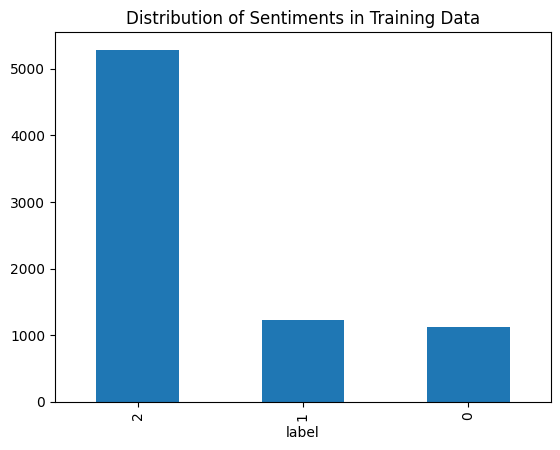

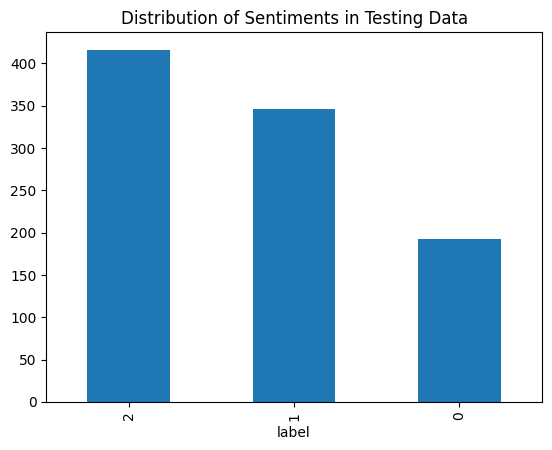

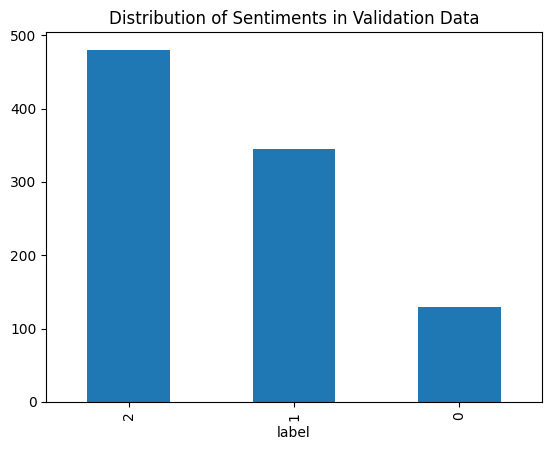

In [3]:
# Show distribution of sentiments in the training data
df_train = pd.DataFrame(train_data)
df_train['label'].value_counts().plot(kind='bar')
plt.title("Distribution of Sentiments in Training Data")
plt.show()

# Show distribution of sentiments in the testing data
df_test = pd.DataFrame(test_data)
df_test['label'].value_counts().plot(kind='bar')
plt.title("Distribution of Sentiments in Testing Data")
plt.show()

# Show distribution of sentiments in the validation data
df_validation = pd.DataFrame(validation_data)
df_validation['label'].value_counts().plot(kind='bar')
plt.title("Distribution of Sentiments in Validation Data")
plt.show()

In [4]:
# Clean Tweets
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@[A-Za-z0-9]+', '', text)  # Remove mentions
    text = re.sub(r'#', '', text)  # Remove hashtags symbol
    return text

df_train['cleaned_text'] = df_train['text'].apply(clean_text)
df_test['cleaned_text'] = df_test['text'].apply(clean_text)
df_validation['cleaned_text'] = df_validation['text'].apply(clean_text)

# Build baseline models

In [5]:
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))

X_train = vectorizer.fit_transform(df_train['cleaned_text'])
y_train = df_train['label']

X_val = vectorizer.transform(df_validation['cleaned_text'])
y_val = df_validation['label']

X_test = vectorizer.transform(df_test['cleaned_text'])
y_test = df_test['label']

In [6]:
# Train the model
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Validation predictions
val_predictions = clf.predict(X_val)
print("Validation Set Results:")
print(classification_report(y_val, val_predictions))

# Test predictions
test_predictions = clf.predict(X_test)
print("Test Set Results:")
print(classification_report(y_test, test_predictions))

Validation Set Results:
              precision    recall  f1-score   support

           0       0.47      0.07      0.12       130
           1       0.59      0.08      0.13       345
           2       0.51      0.95      0.67       480

    accuracy                           0.52       955
   macro avg       0.53      0.37      0.31       955
weighted avg       0.54      0.52      0.40       955

Test Set Results:
              precision    recall  f1-score   support

           0       0.76      0.40      0.52       192
           1       0.91      0.30      0.46       346
           2       0.54      0.96      0.69       416

    accuracy                           0.61       954
   macro avg       0.74      0.55      0.56       954
weighted avg       0.72      0.61      0.57       954



## Prepare Data for BERT

In [7]:
# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [9]:
class FinancialNewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        """
        Initializes the dataset.

        Args:
            texts (list of str): The text data (e.g., news headlines).
            labels (list of int): Corresponding labels (e.g., sentiment).
            tokenizer: Tokenizer for processing text data.
            max_length (int): Maximum token length for each input.
        """
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        """Returns the number of samples in the dataset."""
        return len(self.texts)

    def __getitem__(self, idx):
        """
        Fetches the tokenized text and label for a given index.

        Args:
            idx (int): Index of the data to fetch.

        Returns:
            dict: A dictionary containing input IDs, attention mask, and label.
        """
        text = self.texts[idx]
        label = self.labels[idx]

        # Tokenize the text
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long)
        }



# Prepare the training dataset
train_dataset = FinancialNewsDataset(
    texts=train_data['text'],
    labels=train_data['label'],
    tokenizer=tokenizer,
    max_length=128
)

# Prepare the training dataset
test_dataset = FinancialNewsDataset(
    texts=test_data['text'],
    labels=test_data['label'],
    tokenizer=tokenizer,
    max_length=128
)

# Prepare the validation dataset
validation_dataset = FinancialNewsDataset(
    texts=validation_data['text'],
    labels=validation_data['label'],
    tokenizer=tokenizer,
    max_length=128
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
validation_loader = DataLoader(validation_dataset, batch_size=16, shuffle=False)

## Analysis using BERT

In [10]:
# Load the pre-trained BERT model for classification
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(set(train_data['label']))  # Number of unique sentiment labels
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
optimizer = AdamW(model.parameters(), lr=5e-5)

# Set up a learning rate scheduler
num_training_steps = len(train_loader) * 5  # Assuming 5 epochs
lr_scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [12]:
def train_model_with_metrics(
    model, train_loader, validation_loader, test_loader=None, optimizer=None, 
    lr_scheduler=None, num_epochs=5, device='cuda'
):
    model.to(device)
    train_losses, val_losses, test_losses = [], [], []  # To track losses
    train_accuracies, val_accuracies, test_accuracies = [], [], []  # To track accuracies
    
    for epoch in range(num_epochs):
        # ---------------------
        # Training Phase
        # ---------------------
        model.train()
        train_loss, correct_train, total_train = 0, 0, 0
        
        for batch in train_loader:
            batch = {key: val.to(device) for key, val in batch.items()}
            
            # Forward pass
            outputs = model(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask'],
                labels=batch['labels']
            )
            loss = outputs.loss
            train_loss += loss.item()
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Accuracy calculation
            predictions = outputs.logits.argmax(dim=-1)
            correct_train += (predictions == batch['labels']).sum().item()
            total_train += batch['labels'].size(0)
        
        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train * 100)
        
        # ---------------------
        # Validation Phase
        # ---------------------
        model.eval()
        val_loss, correct_val, total_val = 0, 0, 0
        
        with torch.no_grad():
            for batch in validation_loader:
                batch = {key: val.to(device) for key, val in batch.items()}
                
                outputs = model(
                    input_ids=batch['input_ids'],
                    attention_mask=batch['attention_mask'],
                    labels=batch['labels']
                )
                loss = outputs.loss
                val_loss += loss.item()
                
                predictions = outputs.logits.argmax(dim=-1)
                correct_val += (predictions == batch['labels']).sum().item()
                total_val += batch['labels'].size(0)
        
        val_losses.append(val_loss / len(validation_loader))
        val_accuracies.append(correct_val / total_val * 100)

        # ---------------------
        # Test Phase
        # ---------------------
        if test_loader:
            test_loss, correct_test, total_test = 0, 0, 0
            
            with torch.no_grad():
                for batch in test_loader:
                    batch = {key: val.to(device) for key, val in batch.items()}
                    
                    outputs = model(
                        input_ids=batch['input_ids'],
                        attention_mask=batch['attention_mask'],
                        labels=batch['labels']
                    )
                    loss = outputs.loss
                    test_loss += loss.item()
                    
                    predictions = outputs.logits.argmax(dim=-1)
                    correct_test += (predictions == batch['labels']).sum().item()
                    total_test += batch['labels'].size(0)
            
            test_losses.append(test_loss / len(test_loader))
            test_accuracies.append(correct_test / total_test * 100)
        
        # Print epoch metrics
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print(f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%")
        print(f"Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracies[-1]:.2f}%")
        if test_loader:
            print(f"Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {test_accuracies[-1]:.2f}%")
        print("-" * 50)

    # ---------------------
    # Plotting
    # ---------------------
    # Loss Plot
    plt.figure()
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    if test_loader:
        plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Across Epochs')
    plt.legend()
    plt.show()
    
    # Accuracy Plot
    plt.figure()
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
    if test_loader:
        plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy Across Epochs')
    plt.legend()
    plt.show()

Epoch 1/5
Train Loss: 0.5217, Train Accuracy: 80.26%
Validation Loss: 0.9191, Validation Accuracy: 60.84%
Test Loss: 0.4437, Test Accuracy: 84.17%
--------------------------------------------------
Epoch 2/5
Train Loss: 0.2691, Train Accuracy: 90.31%
Validation Loss: 0.9276, Validation Accuracy: 65.45%
Test Loss: 0.4797, Test Accuracy: 83.86%
--------------------------------------------------
Epoch 3/5
Train Loss: 0.1428, Train Accuracy: 94.92%
Validation Loss: 1.5756, Validation Accuracy: 63.98%
Test Loss: 0.5431, Test Accuracy: 86.27%
--------------------------------------------------
Epoch 4/5
Train Loss: 0.0882, Train Accuracy: 97.03%
Validation Loss: 1.7656, Validation Accuracy: 64.29%
Test Loss: 0.6175, Test Accuracy: 86.37%
--------------------------------------------------
Epoch 5/5
Train Loss: 0.0702, Train Accuracy: 97.52%
Validation Loss: 1.8926, Validation Accuracy: 62.51%
Test Loss: 0.7054, Test Accuracy: 84.07%
--------------------------------------------------


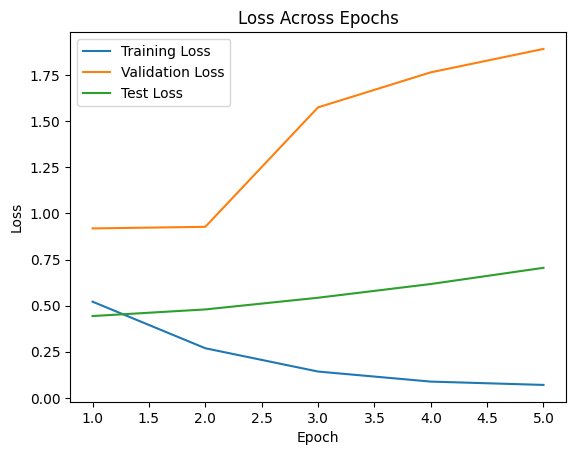

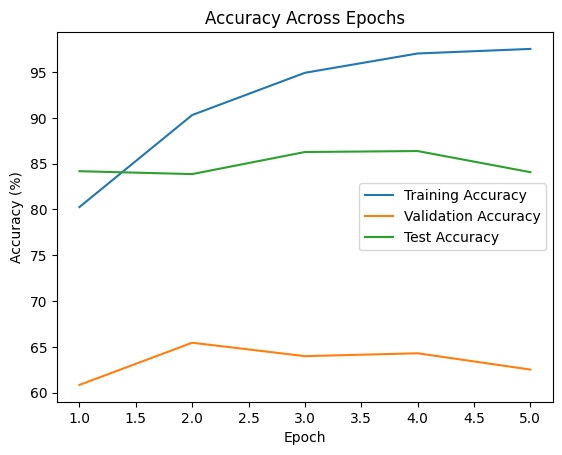

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_model_with_metrics(
    model,
    train_loader,
    validation_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    lr_scheduler=lr_scheduler,
    num_epochs=5,
    device=device
)